In [1]:
%load_ext autoreload
%autoreload 2
%pip install colour ruptures
import pandas as pd
import numpy as np
import bz2
import csv
import io
import json
import re
import time
import random
import requests
import datetime
from tqdm import tqdm
import json
from matplotlib import ticker
from colour import Color
import ruptures as rpt
from pathlib import Path
from pprint import pprint
from typing import List, Dict
from dateutil.relativedelta import relativedelta
import lsde2021.csv as csvutils
import lsde2021.utils as utils
import lsde2021.download as dl
import lsde2021.changepoints as cp
from pyspark.sql import SparkSession
import pyspark.sql.types as T
import pyspark.sql.functions as F

import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20,3)

Note: you may need to restart the kernel to use updated packages.


In [2]:
MAX_MEMORY = "30G"

spark = SparkSession \
    .builder \
    .appName("parse-wikipedia-sql-dumps") \
    .config("spark.executor.memory", MAX_MEMORY) \
    .config("spark.driver.memory", MAX_MEMORY) \
    .config('spark.driver.maxResultSize', MAX_MEMORY) \
    .config('spark.ui.showConsoleProgress', 'false') \
    .getOrCreate()
sc = spark.sparkContext

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
21/11/03 17:48:52 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
21/11/03 17:48:53 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
21/11/03 17:48:53 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
21/11/03 17:48:53 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
21/11/03 17:48:53 WARN Utils: Service 'SparkUI' could not bind on port 4043. Attempting port 4044.
21/11/03 17:48:53 WARN Utils: Service 'SparkUI' could not bind on port 4044. Attempting port 4045.


In [118]:
stringency = spark.read.format("parquet").load(f"../nvme/oxcgrt-covid-policy-tracker/OxCGRT_withnotes.parquet")
languages = spark.read.format("parquet").load(f"./data/languages.parquet")
# languages.show()
# stringency.show()

+-------------------+-----------+---------------+--------------------+
|               Date|CountryName|StringencyIndex|               Notes|
+-------------------+-----------+---------------+--------------------+
|2020-01-01 00:00:00|    Germany|            0.0|[The existing cod...|
|2020-01-02 00:00:00|    Germany|            0.0|                  []|
|2020-01-03 00:00:00|    Germany|            0.0|                  []|
|2020-01-04 00:00:00|    Germany|            0.0|                  []|
|2020-01-05 00:00:00|    Germany|            0.0|                  []|
|2020-01-06 00:00:00|    Germany|            0.0|                  []|
|2020-01-07 00:00:00|    Germany|            0.0|                  []|
|2020-01-08 00:00:00|    Germany|            0.0|                  []|
|2020-01-09 00:00:00|    Germany|            0.0|                  []|
|2020-01-10 00:00:00|    Germany|            0.0|                  []|
|2020-01-11 00:00:00|    Germany|            0.0|                  []|
|2020-

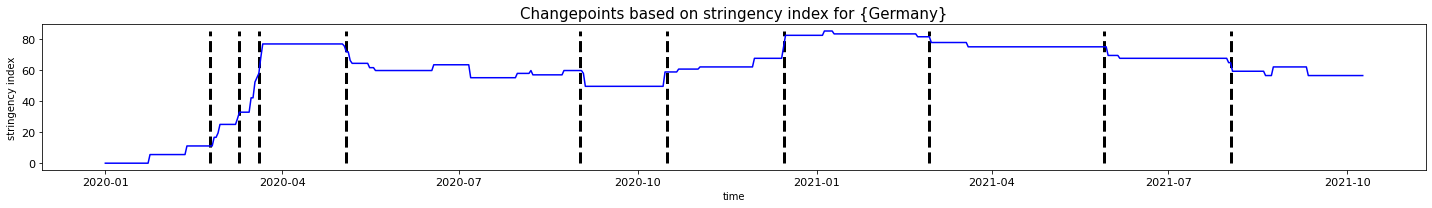

In [103]:
country_stringency, changepoints = cp.get_change_points(stringency, "Germany")
country_stringency.show()
cp.plot_changepoints(
    country_stringency.select("Date", "StringencyIndex").toPandas().set_index("Date"),
    changepoints,
    title="Changepoints based on stringency index for {Germany}"
)

In [78]:
def plot_with_stringency(s, pageviews, label="Pageviews", title=None, smoothing = 50, fontsize=15, figsize=(12, 7), savefig=None):
    fig, ax = plt.subplots(figsize=figsize)
    ax2 = ax.twinx()
    
    ax.tick_params(axis='both', which='major', labelsize=fontsize * 3/4)
    ax.tick_params(axis='both', which='minor', labelsize=fontsize * 3/4)
    
    ax.set_xlabel("time", labelpad=20, size=fontsize)
    ax.set_ylabel("stringency index", labelpad=20, size=fontsize)
    ax2.set_ylabel("absolute page views", labelpad=20, size=fontsize)
    
    assert len(pageviews) > smoothing
    
    ax.plot(s.index[:len(pageviews)-smoothing], s["StringencyIndex"][:len(pageviews)-smoothing], label="Stringency Index", color="gray", linestyle='--', linewidth=2)
    ax2.plot(pageviews.index[:-smoothing], utils.smoothing_window(pageviews["page_views"], radius=smoothing), label=label, color="blue", linestyle='-', linewidth=3)

    plt.legend(fontsize=fontsize)
    if title:
        plt.title(title, fontsize=fontsize, pad=20)
    plt.tight_layout()
    if savefig:
        Path(savefig).parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(savefig)
    plt.show()

In [79]:
exclude = ["disambiguation", "wikipedia", "main topic articles", "stubs"]

In [80]:
def did(year_df, changepoint, control_changepoint, topic_level=4, window_size=relativedelta(days=10), relative=False):
    # control_changepoint = changepoint.replace(year=2019)
    control_start, control_end = control_changepoint - window_size, control_changepoint + window_size
    target_start, target_end = changepoint - window_size, changepoint + window_size

    # control_days = list(dl.date_range(control_start, control_end))
    # target_days = list(dl.date_range(target_start, target_end))
    # print(target_start, target_end)
    # print(control_start, control_end)
    
    # exlude known bad topics
    year_df = year_df.filter(~F.lower("topic").rlike("|".join(["(" + pat + ")" for pat in exclude])))
    
    pre_target_mean = year_df \
        .filter((F.lit(target_start) <= F.col("date")) & (F.col("date") <= F.lit(changepoint))) \
        .fillna(0) \
        .groupBy("topic", "dbname", "wiki_code", "language") \
        .agg(F.mean(f"level{topic_level}_daily_total").alias("pre_target_mean"))

    pre_control_mean = year_df \
        .filter((F.lit(control_start) <= F.col("date")) & (F.col("date") <= F.lit(control_changepoint))) \
        .fillna(0) \
        .groupBy("topic", "dbname", "wiki_code", "language") \
        .agg(F.mean(f"level{topic_level}_daily_total").alias("pre_control_mean"))

    post_target_mean = year_df \
        .filter((F.lit(changepoint) <= F.col("date")) & (F.col("date") <= F.lit(target_end))) \
        .fillna(0) \
        .groupBy(f"topic", "dbname", "wiki_code", "language") \
        .agg(F.mean(f"level{topic_level}_daily_total").alias("post_target_mean"))

    post_control_mean = year_df \
        .filter((F.lit(control_changepoint) <= F.col("date")) & (F.col("date") <= F.lit(control_end))) \
        .fillna(0) \
        .groupBy(f"topic", "dbname", "wiki_code", "language") \
        .agg(F.mean(f"level{level}_daily_total").alias("post_control_mean")) \

    diff = pre_target_mean.join(pre_control_mean, on=["topic", "dbname", "wiki_code", "language"], how="inner")
    diff = diff.join(post_target_mean, on=["topic", "dbname", "wiki_code", "language"], how="inner")
    diff = diff.join(post_control_mean, on=["topic", "dbname", "wiki_code", "language"], how="inner")

    diff = diff.withColumn('control_diff', ( F.col("pre_control_mean") - F.col("post_control_mean") ) )
    diff = diff.withColumn('target_diff', ( F.col("post_target_mean") - (F.col("pre_target_mean") + F.col("control_diff")) ) )
    diff = diff.withColumn('rel_diff', ( F.col("post_target_mean") / (F.col("pre_target_mean") + F.col("control_diff")) ) )
    
    round_digits = 10 if relative else 0
    diff_key = "rel_diff" if relative else "target_diff"
    diff = diff.sort(F.col(diff_key).desc()).select(
        "topic", # "dbname", "wiki_code", "language",
        F.round(diff_key, round_digits).alias("diff"),
        F.round("pre_target_mean", round_digits).alias("pre_target_mean"),
        F.round("pre_control_mean", round_digits).alias("pre_control_mean"),
        F.round("post_target_mean", round_digits).alias("post_target_mean"),
        F.round("post_control_mean", round_digits).alias("post_control_mean"),
    )
    return diff

In [81]:
def diff(year_df, changepoint, control_changepoint, topic_level=4, window_size=relativedelta(days=10), relative=False):
    pre_start, pre_end = changepoint - window_size, changepoint
    post_start, post_end = changepoint, changepoint + window_size
    print(pre_start, pre_end, post_start, post_end)
    
    # exlude known bad topics
    year_df = year_df.filter(~F.lower("topic").rlike("|".join(["(" + pat + ")" for pat in exclude])))
    
    pre_mean = year_df \
        .filter((F.lit(pre_start) <= F.col("date")) & (F.col("date") <= F.lit(pre_end))) \
        .fillna(0) \
        .groupBy("topic", "dbname", "wiki_code", "language") \
        .agg(F.mean(f"level{topic_level}_daily_total").alias("pre_mean"))

    post_mean = year_df \
        .filter((F.lit(post_start) <= F.col("date")) & (F.col("date") <= F.lit(post_end))) \
        .fillna(0) \
        .groupBy("topic", "dbname", "wiki_code", "language") \
        .agg(F.mean(f"level{topic_level}_daily_total").alias("post_mean"))

    diff = pre_mean.join(post_mean, on=["topic", "dbname", "wiki_code", "language"], how="inner")
    
    diff = diff.withColumn('rel_diff', ( F.col("post_mean") / F.col("pre_mean") ) )
    diff = diff.withColumn('abs_diff', ( F.col("post_mean") - F.col("pre_mean") ) )
    
    round_digits = 10 if relative else 0
    diff_key = "rel_diff" if relative else "abs_diff"
    diff = diff.sort(F.col(diff_key).desc()).select(
        "topic", # "dbname", "wiki_code", "language",
        F.round(diff_key, round_digits).alias("diff"),
        F.round("rel_diff", round_digits).alias("rel_diff"),
        F.round("abs_diff", round_digits).alias("abs_diff"),
    )
    return diff

In [82]:
def plot_topics(topics, fontsize=17, figsize=(12, 7), relative=False, risers=True, title=None, savefig=None):

    fig, ax = plt.subplots(figsize=figsize)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    
    (pre_start, pre_end) = (Color("blue"), Color("purple"))
    (post_start, post_end) = (Color("red"), Color("orange"))

    y_pos = np.arange(len(topics))
    
    # print(y_pos)
    # print(topics["topic"].tolist())
    
    # print(len(colors), len(y_pos), len(topics))
    # print(len(pre_start.range_to(pre_end,len(topics))))
    # print(len(topics))
    colors = [c.hex for c in pre_start.range_to(pre_end, len(topics))]
    if risers:
        colors = [c.hex for c in post_start.range_to(post_end,len(topics))]

    ax.barh(0 + 2 * y_pos, topics["diff"], color=colors, align='center')
    # ax.barh(1 + 2 * y_pos, top_n["post_control_mean"], color=post_colors, alpha=0.2, align='center')

    ax.tick_params(axis="both", labelsize=fontsize, which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

    vals = ax.get_xticks()
    for tick in vals:
        ax.axvline(x=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

    ax.set_xlabel("%s difference page views" % ("Relative" if relative else "Absolute"), labelpad=20, size=fontsize)

    # ax.set_ylabel("Start Station", labelpad=20, size=font_size)
    ax.invert_yaxis()

    ax.yaxis.set_major_locator(ticker.FixedLocator(0.0 + 2 * y_pos))
    ax.yaxis.set_major_formatter(ticker.FixedFormatter(topics["topic"]))
    ax.set_yticklabels(topics["topic"])
    
    if title:
        plt.title(title, fontsize=fontsize, pad=20)
    plt.tight_layout()
    if savefig:
        Path(savefig).parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(savefig)
    
    plt.show()

found 11 changepoints for Germany (de)


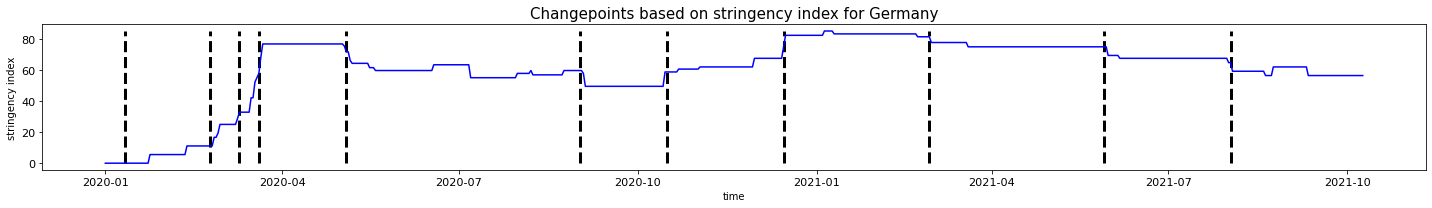

found 11 changepoints for Austria (de)


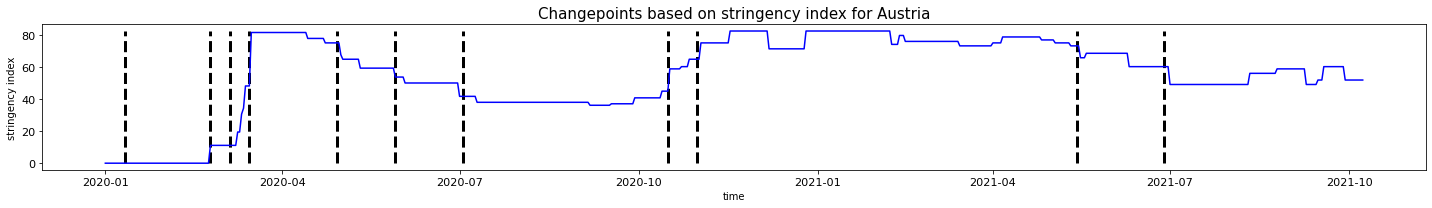

In [125]:
window_size = 15
level = 4
relative = False

def to_date2(d):
    d = d.timetuple()
    return f"{d.tm_year}-{d.tm_mon}-{d.tm_mday}"

def to_date(d):
    d = d.timetuple()
    return f"{d.tm_mday}/{d.tm_mon}/{d.tm_year}"

for country_group in ["de"]: # , "en", "de", "it"]: # ["de", "nl", "en", "it"]:
    for country in cp.COUNTRIES[country_group]:
        try:
            country_stringency, changepoints = cp.get_change_points(stringency, country)
        except rpt.exceptions.BadSegmentationParameters as e:
            print(e)
            changepoints = []
            
        # include set of known global changepoints
        changepoints = [
            datetime.date(2020, 1, 11) # first death in china
        ] + changepoints # [c.to_pydatetime().date() for c in changepoints]
        print(f"found {len(changepoints)} changepoints for {country} ({country_group})")
        
        stringency_dataset = dict(
            country=dict(
                group=country_group,
                name=country_stringency.select("CountryName").first().CountryName,
                code=country_stringency.select("CountryCode").first().CountryCode,
            ),
            stringency=country_stringency.select("Date", "StringencyIndex", "Notes").toJSON().collect(),
            changepoints=changepoints,
        )
        
        out_path = Path("./website/public/data")
        stringency_out_path = out_path / country_group / country / "stringency_changepoints.json"
        stringency_out_path.parent.mkdir(parents=True, exist_ok=True)
        # print(stringency_out_path)
        
        with open(stringency_out_path, "w") as f:
            json.dump(stringency_dataset, f, indent=2, sort_keys=True, default=str)
        
        cp.plot_changepoints(
            country_stringency.select("Date", "StringencyIndex").toPandas().set_index("Date"),
            changepoints,
            title=f"Changepoints based on stringency index for {country}",
            savefig=f"./figs/results/changepoint_detected_{country_group}.pdf")
        plt.show()
        
        continue

        country_stringency_2020 = country_stringency.filter(
            (F.lit(datetime.date(2020,1,1)) <= F.col("Date"))
            & (F.col("Date") <= F.lit(datetime.date(2021,1,1)))
        ).toPandas().set_index("Date")

        # load the entire year data
        # all_days = list(dl.date_range( datetime.date(2019, 1, 1), datetime.date(2019, 12, 31) )) # [:10]
        # all_days += list(dl.date_range( datetime.date(2020, 1, 1), datetime.date(2020, 12, 31) )) # [:200

        print(f"collecting samples for {country}")
        year_df = spark.read.format("parquet").load(f"../nvme/country_pageviews/pageviews_{country_group}.parquet")
        year_df = year_df.filter(F.col(f"level{level}_daily_total").isNotNull())

        #for day in tqdm(all_days):
        #    data = pageview_complete_per_topic / Path("/".join(dl.wikimedia_pageview_complete_local_file(day, monthly=False))).with_suffix(".parquet")
        #    df = spark.read.format("parquet").load(str(data / f"group={country_group}"))
        #    
        #    df = df.withColumn("date", F.lit(day))
        #    if year_df is None:
        #        year_df = df
        #    else:
        #        year_df = year_df.union(df)

        total_attention = year_df \
            .select("date", f"level{level}_daily_total") \
            .groupBy("date") \
            .agg(F.sum(f"level{level}_daily_total").alias("page_views")) \
            .sort(F.col("date").asc()) \
            .toPandas().set_index("date")
        print(total_attention.head())
        plot_with_stringency(
            country_stringency.toPandas().set_index("Date"),
            total_attention,
            label="Total pageviews",
            title=f"Total pageviews for {country}",
            savefig=f"./figs/results/total_pageviews_{country}.pdf"
        )
        plt.show()

        # for topic in ["medicine", "sports", "television", "computer games", "mathematics", "homeoffice", "home-office"]:
        # for topic in ["games", "mathematics", "medicine", "sports", "television"]:
        for topic in []: # "medicine", "music", "entertainment"]:
            # continue
            # .filter((F.lit(control_changepoint) <= F.col("date")) & (F.col("date") <= F.lit(control_end))) \
            # mean_topic_page_views = year_df \
            #     .select("date", f"level{level}_daily_total") \
            #     .groupBy("date") \
            #     .agg(F.sum(f"level{level}_daily_total").alias("sum_page_views")) \
                # .toPandas().set_index("date")

            topic_page_views = year_df \
                .filter(F.lower(F.col("topic")) == topic.lower()) \
                .select("date", f"level{level}_daily_total") \
                .groupBy("date") \
                .agg(F.sum(f"level{level}_daily_total").alias("page_views"))

            # print(country_stringency.filter((F.lit(datetime.date(2020,1,1)) <= F.col("Date")) & (F.col("Date") <= F.lit(datetime.date(2021,1,1)))).limit(10).toPandas().set_index("Date").head())
            # break
            # topic_page_views = topic_page_views \
            #     .join(mean_topic_page_views, on="date", how="inner")
            # topic_page_views = topic_page_views \
            #     .join(country_stringency.select(F.col("Date").alias("date"), "StringencyIndex"), on="date", how="inner") \
            #     .withColumn("page_views", F.col("page_views") / F.col("sum_page_views") ) \
            #     .toPandas().set_index("date")
            # 
            # topic_page_views.show()

            plot_with_stringency(
                country_stringency_2020,
                # topic_page_views, # country_stringency, # .toPandas().set_index("Date"),
                # .filter((F.lit(datetime.date(2020,1,1)) <= F.col("Date")) & (F.col("Date") <= F.lit(datetime.date(2021,1,1)))).toPandas().set_index("Date"),
                # & (F.col("date") <= F.lit(datetime.date(2021,1,1))
                topic_page_views.filter((F.lit(datetime.date(2020,1,1)) <= F.col("date"))).toPandas().set_index("date"),
                # .filter((F.lit(datetime.date(2020,1,1)) <= F.col("date")) & (F.col("date") <= F.lit(datetime.date(2021,1,1)))).toPandas().set_index("date"),
                label=f"Pageviews for topic {topic}",
                title=f"Pageviews for {countries[country_group]}",
                savefig=f"./figs/results/single_topic_pageviews_{country_group}_{topic}.pdf"
            )
            plt.show()

        # for each changepoint, get risers and decreasers
        pprint(changepoints)
        for changepoint in changepoints[:3]:
            start = time.time()
            control_changepoint = changepoint
            day_diff = 0
            while True:
                try:
                    control_changepoint = changepoint.replace(year=2019, day=changepoint.day - day_diff)
                    break
                except ValueError:
                    day_diff += 1
            method = did
            method = diff
            diff_df = method(
                year_df,
                changepoint=changepoint,
                control_changepoint=control_changepoint,
                topic_level=level,
                window_size=relativedelta(days=window_size),
                relative=relative,
            )
            diff_df = diff_df.toPandas()
            print("took %.2f seconds" % (time.time() - start))
            
            # print(diff.shape)
            # print(diff.head())
            # assert len(diff) > 0
            # .set_index("date")

            print(diff_df.iloc[:10])
            print(diff_df.iloc[-10:])
            plot_topics(
                diff_df.iloc[:10],
                risers=True,
                relative=relative,
                savefig=f"./figs/results/topic_increase_{country_group}_{to_date2(changepoint)}.pdf",
                title="Changepoint %s ($\pm$ %d days)" % (to_date(changepoint), window_size)
            )
            plot_topics(
                diff_df.iloc[-10:],
                risers=False,
                relative=relative,
                savefig=f"./figs/results/topic_decrease_{country_group}_{to_date2(changepoint)}.pdf",
                title="Changepoint %s ($\pm$ %d days)" % (to_date(changepoint), window_size)
            )

In [ ]:
pageview_complete_per_topic = Path("../nvme/pageview_complete_per_topic")

group = "de"
group = "nl"
# group = "en"

year = 2020
all_days = list(dl.date_range(
    datetime.date(year, 1, 1),
    datetime.date(year, 12, 31),
))
# pprint(all_days)

year_df = None
for day in tqdm(all_days):
    data = pageview_complete_per_topic / Path("/".join(dl.wikimedia_pageview_complete_local_file(day, monthly=False))).with_suffix(".parquet")
    df = spark.read.format("parquet").load(str(data / f"group={group}"))
    df = df.filter(F.col("level4_daily_total").isNotNull())
    df = df.withColumn("date", F.lit(day))
    
    if year_df is None:
        year_df = df
    else:
        year_df = year_df.union(df)

In [ ]:
pageview_complete_per_topic = Path("../nvme/pageview_complete_per_topic")

changepoint = datetime.date(2020, 1, 15)
control_changepoint = changepoint.replace(year=2019)

print(changepoint, control_changepoint)

window_size = relativedelta(days=10)

def to_date(d):
    d = pre_day.timetuple()
    return f"{d.tm_year}-{d.tm_mon}-{d.tm_mday}"
    
control_start, control_end = control_changepoint - window_size, control_changepoint + window_size
target_start, target_end = changepoint - window_size, changepoint + window_size

control_days = list(dl.date_range(control_start, control_end))
target_days = list(dl.date_range(target_start, target_end))

In [ ]:
# diff in diff
level = 4
# level = 1

pre_target_mean = year_df \
    .filter((F.lit(target_start) <= F.col("date")) & (F.col("date") <= F.lit(changepoint))) \
    .fillna(0) \
    .groupBy("topic", "dbname", "wiki_code", "language") \
    .agg(F.mean(f"level{level}_daily_total").alias("pre_target_mean")) \
    # .withColumn("pre_target_mean", F.log("pre_target_mean"))

pre_control_mean = year_df \
    .filter((F.lit(control_start) <= F.col("date")) & (F.col("date") <= F.lit(control_changepoint))) \
    .fillna(0) \
    .groupBy("topic", "dbname", "wiki_code", "language") \
    .agg(F.mean(f"level{level}_daily_total").alias("pre_control_mean")) \
    # .withColumn("pre_control_mean", F.log("pre_control_mean"))

post_target_mean = year_df \
    .filter((F.lit(changepoint) <= F.col("date")) & (F.col("date") <= F.lit(target_end))) \
    .fillna(0) \
    .groupBy(f"topic", "dbname", "wiki_code", "language") \
    .agg(F.mean(f"level{level}_daily_total").alias("post_target_mean")) \
    # .withColumn("post_target_mean", F.log("post_target_mean"))

post_control_mean = year_df \
    .filter((F.lit(control_changepoint) <= F.col("date")) & (F.col("date") <= F.lit(control_end))) \
    .fillna(0) \
    .groupBy(f"topic", "dbname", "wiki_code", "language") \
    .agg(F.mean(f"level{level}_daily_total").alias("post_control_mean")) \
    # .withColumn("post_control_mean", F.log("post_control_mean"))

diff = pre_target_mean.join(pre_control_mean, on=["topic", "dbname", "wiki_code", "language"], how="inner")
diff = diff.join(post_target_mean, on=["topic", "dbname", "wiki_code", "language"], how="inner")
diff = diff.join(post_control_mean, on=["topic", "dbname", "wiki_code", "language"], how="inner")

diff = diff.withColumn('diff', ( F.col("post_target_mean") / F.col("pre_target_mean") ) )
diff = diff.withColumn('control_diff', ( F.col("pre_control_mean") - F.col("post_control_mean") ) )
diff = diff.withColumn('target_diff', ( F.col("post_target_mean") - (F.col("pre_target_mean") + F.col("control_diff")) ) )

diff.sort(F.col("target_diff").desc()).select(
    "topic", "dbname", "wiki_code", "language",
    F.round("target_diff", 0).alias("target_diff"),
    F.round("pre_target_mean", 0).alias("pre_target_mean"),
    F.round("pre_control_mean", 0).alias("pre_control_mean"),
    F.round("post_target_mean", 0).alias("post_target_mean"),
    F.round("post_control_mean", 0).alias("post_control_mean"),
).show()

diff.sort(F.col("diff").desc()).select(
    "topic", "dbname", "wiki_code", "language",
    F.round("diff", 0).alias("diff"),
    F.round("pre_target_mean", 0).alias("pre_target_mean"),
    # F.round("pre_control_mean", 0).alias("pre_control_mean"),
    F.round("post_target_mean", 0).alias("post_target_mean"),
    # F.round("post_control_mean", 0).alias("post_control_mean"),
).show()

In [ ]:
topic_diffs = diff.sort(F.col("target_diff").desc()).select(
    "topic", # "dbname", "wiki_code", "language",
    F.round("target_diff", 0).alias("target_diff"),
    F.round("pre_target_mean", 0).alias("pre_target_mean"),
    F.round("pre_control_mean", 0).alias("pre_control_mean"),
    F.round("post_target_mean", 0).alias("post_target_mean"),
    F.round("post_control_mean", 0).alias("post_control_mean"),
).toPandas()
# print(topic_diffs.head())
# print(topic_diffs.tail())

In [ ]:
country_stringency = stringency.filter(F.col("CountryName") == countries[group]).select("Date", "StringencyIndex").toPandas().set_index("Date")

# for each country

# plot the changepoints

# for each changepoint, generate the diff in diff changes

# plot the total per stringency

# plot the topic attention for "medicine", "sports", "television", "computer games", "mathematics", "homeoffice"

topic = "Football"
topic = "Medicine"
single_topic_pageview = year_df \
    .filter(F.lower(F.col("topic")) == topic.lower()) \
    .select("date", f"level{level}_daily_total") \
    .groupBy("date") \
    .agg(F.sum(f"level{level}_daily_total").alias("page_views")) \
    .toPandas().set_index("date")

country_stringency.head()
single_topic_pageview.head()

In [ ]:
total_attention = year_df \
    .select("date", f"level{level}_daily_total") \
    .groupBy("date") \
    .agg(F.sum(f"level{level}_daily_total").alias("page_views")) \
    .toPandas().set_index("date")

In [ ]:
def smoothing_window(vals, radius=50):
    cumvals = np.array(vals).cumsum()
    return (cumvals[radius:] - cumvals[:-radius]) / radius

def plot_with_stringency(s, pageviews, label="Pageviews", title=None, smoothing = 50, fontsize=15, figsize=(12, 7)):
    fig, ax = plt.subplots(figsize=figsize)
    ax2 = ax.twinx()
    
    ax.tick_params(axis='both', which='major', labelsize=fontsize * 3/4)
    ax.tick_params(axis='both', which='minor', labelsize=fontsize * 3/4)
    
    ax.set_xlabel("time", labelpad=20, size=fontsize)
    ax.set_ylabel("stringency index", labelpad=20, size=fontsize)
    ax2.set_ylabel("absolute page views", labelpad=20, size=fontsize)
    
    ax.plot(s.index[:len(pageviews)-smoothing], s["StringencyIndex"][:len(pageviews)-smoothing], label="Stringency Index", color="gray", linestyle='--', linewidth=2)
    ax2.plot(pageviews.index[:-smoothing], smoothing_window(pageviews["page_views"], radius=smoothing), label=label, color="blue", linestyle='-', linewidth=3)

    plt.legend(fontsize=fontsize)
    if title:
        plt.title(title, fontsize=fontsize, pad=20)
    plt.show()
    
# f"Stringency index for {countries[group]}"
plot_with_stringency(country_stringency, single_topic_pageview, label=f"{topic} pageviews")
plot_with_stringency(country_stringency, total_attention, label="Total pageviews")

In [ ]:
from matplotlib import ticker
from colour import Color

def plot_topics(topics, fontsize=17, figsize=(12, 7), risers=True):

    fig, ax = plt.subplots(figsize=figsize)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    
    (pre_start, pre_end) = (Color("blue"), Color("purple"))
    (post_start, post_end) = (Color("red"), Color("orange"))

    y_pos = np.arange(len(topics))
    
    colors = [c.hex for c in pre_start.range_to(pre_end,len(topics))]
    if risers:
        colors = [c.hex for c in post_start.range_to(post_end,len(topics))]

    ax.barh(0 + 2 * y_pos, topics["target_diff"], color=colors, align='center')
    # ax.barh(1 + 2 * y_pos, top_n["post_control_mean"], color=post_colors, alpha=0.2, align='center')

    ax.tick_params(axis="both", labelsize=fontsize, which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

    vals = ax.get_xticks()
    for tick in vals:
        ax.axvline(x=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

    ax.set_xlabel("Absolute difference page views", labelpad=20, size=fontsize)

    # ax.set_ylabel("Start Station", labelpad=20, size=font_size)
    ax.invert_yaxis()

    ax.yaxis.set_major_locator(ticker.FixedLocator(0.5 + 2 * y_pos))
    ax.yaxis.set_major_formatter(ticker.FixedFormatter(topics["topic"]))
    ax.set_yticklabels(topics["topic"])
    plt.show()
    
plot_topics(topic_diffs.iloc[:10], risers=True)
plot_topics(topic_diffs.iloc[-10:], risers=False)

In [ ]:
pageview_complete_per_topic = Path("../nvme/pageview_complete_per_topic")
group = "nl"

days_2019 = list(dl.date_range(control_start, control_end))
target_days = list(dl.date_range(target_start, target_end))
all_days = list(dl.date_range(datetime.date(2019, 1, 1), datetime.date(2019, 2, 1))) + list(dl.date_range(datetime.date(2020, 1, 1), datetime.date(2020, 2, 1)))

changepoint_df = None
for day in all_days:
    data = pageview_complete_per_topic / Path("/".join(dl.wikimedia_pageview_complete_local_file(day, monthly=False))).with_suffix(".parquet")
    df = spark.read.format("parquet").load(str(data / f"group={group}"))
    df = df.filter(F.col("level4_daily_total").isNotNull())
    df = df.select("topic", "dbname", "wiki_code", "language", "level1_daily_total", "level2_daily_total", "level3_daily_total", "level4_daily_total")
    df = df.withColumn("date", F.lit(day))
    
    if changepoint_df is None:
        changepoint_df = df
    else:
        changepoint_df = changepoint_df.union(df)
        pass
    
# changepoint_df.limit(10).show()
changepoint_df.write.csv("../nvme/yannick-nl.csv")

In [ ]:
# pre_df = pre_df.groupBy("topic", "dbname", "wiki_code", "language").agg(F.sum("level4_daily_total"))
# changepoint_df.show()
# changepoint_df.printSchema()
# start simple, compute the mean pre and post changepoint and take largest relative difference
print(target_start, changepoint)
level = 1

pre_pageviews = changepoint_df \
    .filter((F.lit(target_start) <= F.col("date")) & (F.col("date") <= F.lit(changepoint))) \
    .groupBy("topic", "dbname", "wiki_code", "language") \
    .agg(F.mean(f"level{level}_daily_total").alias("mean_pageviews_pre"))
# pre_pageviews.select("date").distinct().show()
# pre_pageviews.show()

post_pageviews = changepoint_df \
    .filter((F.lit(changepoint) <= F.col("date")) & (F.col("date") <= F.lit(target_end))) \
    .groupBy(f"topic", "dbname", "wiki_code", "language") \
    .agg(F.mean(f"level{level}_daily_total").alias("mean_pageviews_post"))
# post_pageviews.select("date").distinct().show()
# post_pageviews.show()

diff = pre_pageviews.join(post_pageviews, on=["topic", "dbname", "wiki_code", "language"], how="inner")
diff = diff.withColumn('diff', ( F.col("mean_pageviews_post") / F.col("mean_pageviews_pre") ) )
# diff = diff.sort(F.col("diff").desc())
# diff.show()

diff.filter(F.col("mean_pageviews_post") > 1_000).sort(F.col("diff").desc()).show()
# diff.sort(F.col("mean_pageviews_post").desc()).show()
# dd1 = dd1.withColumn('Result', ( dd1['A'] - dd1['B'] ) / dd1['A'] )
# 
# diff = pre_pageviews

# .select("date").distinct().show()
# print(changepoint_df.select("topic").distinct().count())